In [1]:
import json
import numpy as np
import pandas as pd
import covasim as cv
import docplex.mp.model as cpx
from tensorflow import keras

import interventions
from data import get_real_samples, get_regional_data
from dataset import process_dataset, one_hot_zones
from eml.backend import cplex_backend
from eml.net import embed
from eml.net.reader import keras_reader
from eml.net.process import ibr_bounds

zones_dictionary = {
    (1, 0, 0, 0): 'W',
    (0, 1, 0, 0): 'Y',
    (0, 0, 1, 0): 'O',
    (0, 0, 0, 1): 'R',
}

df = pd.read_csv('../res/dataset.csv')
net = keras.models.load_model('../res/model')
(xtr, _), (x_scaler, y_scaler) = process_dataset(df, val_split=None, scale_data=True)
x_min, x_max = xtr.min(axis=0), xtr.max(axis=0)

pct_beds_hosp = 370.4 / 100e3
pct_beds_icu = 14.46 / 100e3
pop_size = 400e3
hospital_capacity = pop_size * (pct_beds_hosp + pct_beds_icu)

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


In [2]:
region = 'Emilia-Romagna'
zones = {
    '2020-11-08': 'Y',
    '2020-11-15': 'O',
    '2020-12-10': 'Y',
    '2020-12-21': 'O',
    '2021-02-01': 'Y',
    '2021-02-21': 'O',
    '2021-03-01': 'R',
    '2021-04-12': 'O',
    '2021-04-26': 'Y'
}
real_df = get_real_samples(region=region, zones=zones, scaling_factor=4.46e6 / pop_size)
real_df

,hosp_0,diag_0,dead_0,hosp_1,diag_1,dead_1,hosp_2,diag_2,dead_2,hosp_3,...,diag_39,dead_39,hosp_40,diag_40,dead_40,hosp_41,diag_41,dead_41,init_zone,actuated_zone
0,45.381166,47.174888,0.538117,49.417040,49.417040,0.269058,54.618834,45.470852,0.448430,61.165919,...,193.273543,4.932735,262.152466,194.080717,5.919283,261.704036,194.170404,6.278027,W,Y
1,75.784753,106.905830,0.358744,81.524664,102.511211,0.269058,93.004484,126.278027,1.345291,100.269058,...,157.847534,7.623318,265.919283,191.838565,5.650224,264.573991,176.143498,4.663677,Y,O
2,245.112108,193.721973,4.484305,249.147982,226.905830,4.215247,254.260090,243.946188,4.215247,261.434978,...,67.264574,2.780269,252.825112,80.000000,8.071749,257.488789,127.982063,6.188341,O,Y
3,269.417040,183.049327,3.497758,266.905830,131.659193,4.663677,263.587444,140.717489,6.188341,261.255605,...,181.524664,7.174888,261.793722,160.358744,6.188341,263.856502,196.502242,5.201794,Y,O
4,267.174888,173.991031,5.919283,266.098655,140.179372,4.573991,260.807175,105.650224,5.919283,254.977578,...,162.511211,4.125561,186.098655,153.183857,2.062780,190.403587,165.919283,3.677130,O,Y
5,207.892377,114.260090,1.973094,214.170404,94.260090,3.049327,212.914798,78.295964,6.367713,207.713004,...,253.004484,4.035874,318.116592,308.789238,3.139013,323.587444,262.242152,2.780269,Y,O
6,195.964126,114.080717,2.869955,193.094170,86.008969,4.035874,190.134529,82.600897,3.318386,186.636771,...,283.587444,3.766816,351.569507,227.623318,4.215247,355.336323,218.923767,3.049327,O,R
7,366.995516,189.506726,3.946188,363.587444,139.192825,5.022422,359.730942,152.914798,4.035874,355.067265,...,108.071749,1.524664,166.457399,84.304933,1.524664,169.327354,84.932735,1.165919,R,O


In [3]:
def build_cplex_model(neural_model, input_data, rolling_days=7):
    # PREPROCESS INPUT DATA
    init_zone = one_hot_zones[input_data['init_zone']]
    input_data = pd.DataFrame(input_data.values[:-2].reshape(-1, 3).astype('float'), columns=['hosp', 'diag', 'dead'])
    input_data = input_data.head(len(input_data) // 2).copy()
    input_features = input_data.rolling(rolling_days).mean().iloc[rolling_days - 1:].values.transpose().flatten()
    # add trailing zeros to match scaler expected size, then remove them
    input_features = list(x_scaler.transform(list(input_features) + init_zone + [0] * 4)[:-4])

    # BUILD SURROGATE MODEL
    surrogate_model = keras_reader.read_keras_sequential(neural_model)
    # input features have a fixed values, then we have 4 more values for the decision variables (0/1, being binary)
    surrogate_model.layer(0).update_lb(np.array(input_features + [0] * 4))
    surrogate_model.layer(0).update_ub(np.array(input_features + [1] * 4))
    ibr_bounds(surrogate_model)

    # BUILD INPUT/OUTPUT CPLEX VARIABLES WITH RESPECTIVE CONSTRAINED VALUES
    backend = cplex_backend.CplexBackend()
    cplex_model = cpx.Model()
    x_variables, y_variables, decision_variables = [], [], []
    # input features
    for idx, val in enumerate(input_features):
        var = cplex_model.continuous_var(lb=val, ub=val, name=f'feature_{idx}')
        x_variables.append(var)
    # output values
    for name in ['peak_hosp', 'cum_diag', 'cum_dead']:
        y_variables.append(cplex_model.continuous_var(name=name))
    # binary decision variables (constrained so that is just one of them)
    decision_variables = cplex_model.binary_var_list(keys=4, name=f'zones')
    cplex_model.add_constraint(sum(decision_variables) == 1)
    # process cplex model using eml
    embed.encode(backend, surrogate_model, cplex_model, x_variables + decision_variables, y_variables, 'model')

    # ADD CONSTRAINTS AND OBJECTIVE
    y_variables = np.array(y_variables).reshape(1, -1)
    y_variables = y_scaler.inverse_transform(y_variables).flatten()
    # constraint the output values so that the peak of hospitalized does not exceed 30% of the hospital capacity
    # and the total number of cases and deaths do not exceed the 85% of those same values related to the previous weeks
    bounds = [0.3 * hospital_capacity, 0.85 * input_data['diag'].sum(), 0.85 * input_data['dead'].sum()]
    cplex_model.add_constraints([yv <= bound for yv, bound in zip(y_variables, bounds)])
    # minimize in order to choose the most permissive zone that satisfies all the constraints
    cplex_model.minimize(sum([idx * d for idx, d in enumerate(decision_variables)]))
    return cplex_model, decision_variables

In [4]:
solutions = []
for _, row in real_df.iterrows():
    model, variables = build_cplex_model(neural_model=net, input_data=row)
    solution = model.solve()
    if solution is not None:
        solution = tuple([int(vy.solution_value) for vy in variables])
        solution = zones_dictionary[solution]
    solutions.append((row.iloc[-1], solution))
solutions = pd.DataFrame(solutions, columns=['real', 'predicted'])
solutions

,real,predicted
0,Y,None
1,O,None
2,Y,R
3,O,Y
4,Y,Y
5,O,None
6,R,None
7,O,Y


In [5]:
zones_verbose = {
    'W': 'white',
    'Y': 'yellow',
    'O': 'orange',
    'R': 'red'
}

solutions['predicted'] = [zone if zone is not None else 'R' for zone in solutions['predicted']]
for col in ['real', 'predicted']:
    solutions[col] = [zones_verbose[solution] for solution in solutions[col]]

dates = list(zones.keys())
solutions.index = dates[:-1]
solutions

,real,predicted
2020-11-08,yellow,red
2020-11-15,orange,red
2020-12-10,yellow,red
2020-12-21,orange,yellow
2021-02-01,yellow,yellow
2021-02-21,orange,red
2021-03-01,red,red
2021-04-12,orange,yellow


In [6]:
with open('../res/parameters.json', 'r') as json_file:
  j = json.load(json_file)

intervention_params = j['intervention_params']
initial_params = j['initial_params']
initial_params['end_day'] = dates[-1]

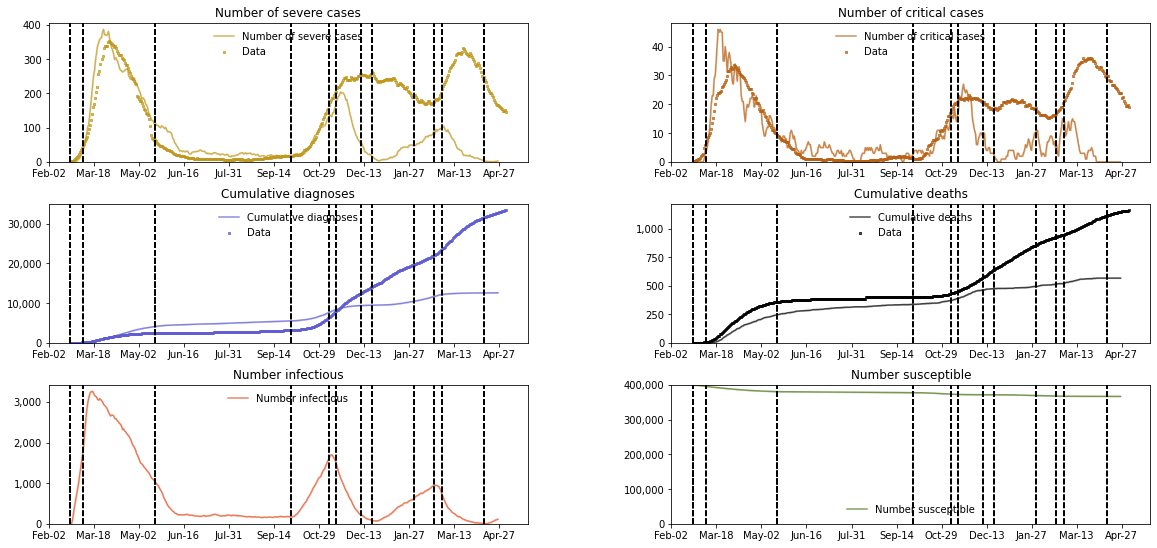

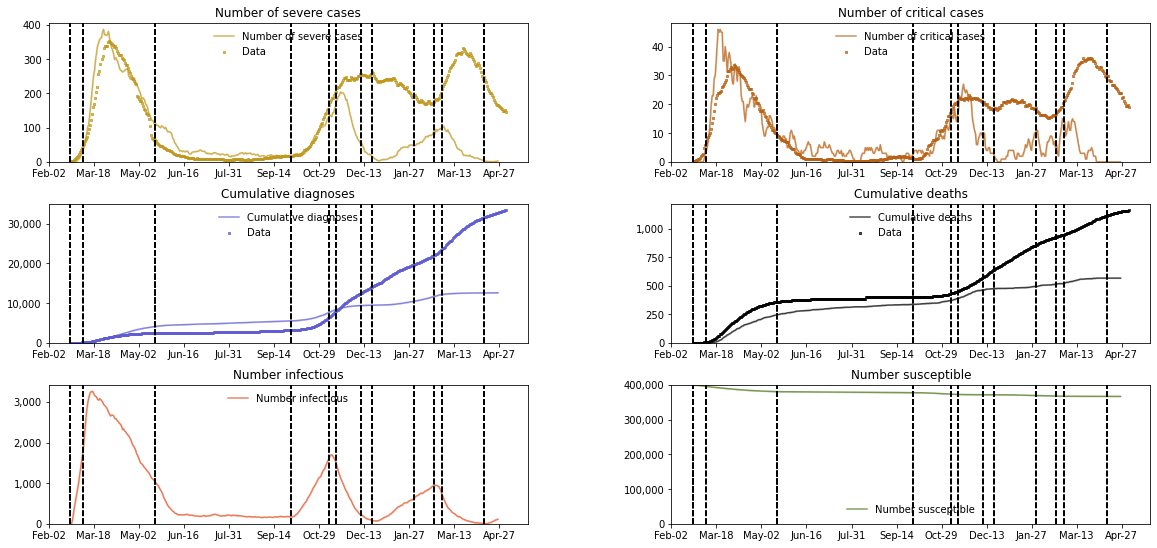

In [8]:
df = get_regional_data(4.46e6 / initial_params['pop_size'])

pre_zones = [
    ('2020-02-24', 'init'),
    ('2020-03-08', 'red'),
    ('2020-05-18', 'summer')
]

intervs = interventions.get_interventions(
    periods={interventions.get_delta(d): z
             for d, z in pre_zones + list(solutions['predicted'].to_dict().items())},
    parameters=intervention_params
)
sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
msim = cv.MultiSim(sim)
msim.run(n_runs=1)
msim.mean()
msim.plot(
    ['n_severe', 'n_critical', 'cum_diagnoses', 'cum_deaths', 'n_infectious', 'n_susceptible'],
    fig_args={'figsize': (18, 8)},
    scatter_args={'s': 5},
    plot_args={'lw': 2},
    interval=45
)